# <u> Rossmann Store Sales Prediction </u>

                                        Team member: Yingjie Yu, Yiru Wang, Feng Wang

In [1]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import operator
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from datetime import datetime
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error

C:\Users\Karl\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pd.set_option('display.max_columns', 40)
pd.set_option('precision', 4)

# <u> 1. Data Set Description <u>

<ul>
<li> <b> train </b>is a dataset with historical sales data for 1,115 Rossmann stores from Jan 1 2013 to July 31, 2015. Each row is daily record. </li>
<li> <b> store</b> is a dataset of all stores. Each row is a store.</li>


Important columns in <b> train, store </b> are:
<ol>
<li>Store - a unique Id for each store</li>
<li>Sales - the turnover for any given day</li>
<li>Customers - the number of customers on a given day</li>
<li>Open - whether the store was open: 0 = closed, 1 = open</li>
<li>StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None</li>
<li>SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools. </li>
<li>StoreType - differentiates between 4 different store models: a, b, c, d. <b>we do not have detail information regarding the store type</b></li> 
<li>Assortment - describes an assortment level: a = basic, b = extra, c = extended</li>
<li>CompetitionDistance - distance in meters to the nearest competitor store</li>
<li>CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened</li>
<li>Promo - indicates whether a store is running a promo on that day</li>
<li>Promo2 - Promo2 is a coupon based mailing campaign that is send to customers of participating stores: 0 = store is not participating, 1 = store is participating</li>
<li>Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2</li>
<li>PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store</li>


</ol>

In [3]:
train = pd.read_csv("train.csv")

In [4]:
train.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1


In [5]:
store = pd.read_csv('store.csv')

In [6]:
store.head(1)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [7]:
train.info() # needs to split date to see time trend, convert category into dummies such as Stateholiday and SchoolHoliday

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [8]:
store.info()  # looking at null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [9]:
len(store[store.Promo2 == 0])   # so the NAN in Promo2SinceWeek/Year, PromoInterval means 0. 544 + 571 = 1115

544

In [10]:
store[store.CompetitionDistance.isnull()] # CompetitionDistance is Nan means no competition, so fill 0

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [11]:
store[store.CompetitionOpenSinceMonth.isnull()].head()  # data not available, fill 0

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


# <u> 2. Data Preparation <u>

In [12]:
types = {'CompetitionOpenSinceYear': np.dtype(int),
         'CompetitionOpenSinceMonth': np.dtype(int),
         'StateHoliday': np.dtype(str),
         'Promo2SinceWeek': np.dtype(int),
         'SchoolHoliday': np.dtype(float),
         'PromoInterval': np.dtype(str)}
train = pd.read_csv("train.csv", parse_dates=[2], dtype=types)
store = pd.read_csv("store.csv")

In [13]:
#Consider only open stores for training. Closed stores wont count into the score.
train = train[train["Open"] != 0]
#Use only Sales bigger then zero. Simplifies calculation of rmspe
train = train[train["Sales"] > 0]

#Join with store
train = pd.merge(train, store, on='Store')

In [14]:
def build_features(features, data):
    
    # Use some properties directly
    # Since Promo2 is a continuous coupon promotion
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', \
                     'SchoolHoliday','StoreType', 'Assortment', 'StateHoliday'])

    # fill NAN in CompetitionDistance,CompetitionOpenSinceMonth and CompetitionOpenSinceYear with 0, for NAN here means no competitor store opened nearby
    data['CompetitionDistance'].fillna(0, inplace = True)
    data['CompetitionOpenSinceYear'].fillna(0, inplace = True)
    data['CompetitionOpenSinceMonth'].fillna(0, inplace = True)
    # fill NAN in PromoInterval with 0, for NAN here means no promo2 is on
    data['PromoInterval'].fillna(0, inplace = True)
    
    # get time features
    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear

    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [15]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

In [16]:
features = []

#augment features
build_features(features, train)
print(features)

['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']


In [17]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,1,4,2015-07-31,5263,555,1,1,0,1.0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,,2015,7,31,31,82.0,0.0,Jul,0
1,1,3,2015-07-30,5020,546,1,1,0,1.0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,,2015,7,30,31,82.0,0.0,Jul,0
2,1,2,2015-07-29,4782,523,1,1,0,1.0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,,2015,7,29,31,82.0,0.0,Jul,0
3,1,1,2015-07-28,5011,560,1,1,0,1.0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,,2015,7,28,31,82.0,0.0,Jul,0
4,1,0,2015-07-27,6102,612,1,1,0,1.0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,,2015,7,27,31,82.0,0.0,Jul,0


In [18]:
X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
y_train = np.log1p(X_train.Sales)    # sales are logged for better regression.
y_valid = np.log1p(X_valid.Sales) 
dtrain = X_train.loc[:,features]
dvalid = X_valid.loc[:,features]
dtrain.head()

,Store,CompetitionDistance,Promo,Promo2,SchoolHoliday,StoreType,Assortment,StateHoliday,DayOfWeek,Month,Day,Year,WeekOfYear,CompetitionOpen,PromoOpen,IsPromoMonth
167746,224,7930.0,0,1,0.0,d,c,0,5,3,1,2014,9,24171.0,14.00,0
543533,721,3590.0,0,1,0.0,a,c,0,4,2,13,2015,7,29.0,32.25,0
610175,808,18620.0,1,1,1.0,a,a,0,2,2,19,2014,8,24170.0,54.25,1
167035,223,2920.0,0,1,0.0,d,c,0,0,12,9,2013,50,218.0,29.75,0
164290,220,1000.0,0,0,1.0,a,a,0,1,4,7,2015,15,79.0,0.00,0


In [19]:
dtrain_dummied = pd.get_dummies(dtrain,columns=['StoreType','Assortment','DayOfWeek','Year','Month','WeekOfYear','StateHoliday'
                                        ], drop_first=True)
dvalid_dummied = pd.get_dummies(dvalid,columns=['StoreType','Assortment','DayOfWeek','Year','Month','WeekOfYear','StateHoliday'
                                        ], drop_first=True)

In [20]:
dtrain_dummied.drop(['Store','Day'],axis=1,inplace = True)
dvalid_dummied.drop(['Store','Day'],axis=1,inplace = True)

In [21]:
dvalid_dummied.columns

Index([u'CompetitionDistance', u'Promo', u'Promo2', u'SchoolHoliday',
       u'CompetitionOpen', u'PromoOpen', u'IsPromoMonth', u'StoreType_b',
       u'StoreType_c', u'StoreType_d', u'Assortment_b', u'Assortment_c',
       u'DayOfWeek_1', u'DayOfWeek_2', u'DayOfWeek_3', u'DayOfWeek_4',
       u'DayOfWeek_5', u'DayOfWeek_6', u'Year_2014', u'Year_2015', u'Month_2',
       u'Month_3', u'Month_4', u'Month_5', u'Month_6', u'Month_7', u'Month_8',
       u'Month_9', u'Month_10', u'Month_11', u'Month_12', u'WeekOfYear_2',
       u'WeekOfYear_3', u'WeekOfYear_4', u'WeekOfYear_5', u'WeekOfYear_6',
       u'WeekOfYear_7', u'WeekOfYear_8', u'WeekOfYear_9', u'WeekOfYear_10',
       u'WeekOfYear_11', u'WeekOfYear_12', u'WeekOfYear_13', u'WeekOfYear_14',
       u'WeekOfYear_15', u'WeekOfYear_16', u'WeekOfYear_17', u'WeekOfYear_18',
       u'WeekOfYear_19', u'WeekOfYear_20', u'WeekOfYear_21', u'WeekOfYear_22',
       u'WeekOfYear_23', u'WeekOfYear_24', u'WeekOfYear_25', u'WeekOfYear_26',
       u'Wee

In [22]:
dvalid_dummied['StateHoliday_c'] = 0

# <u> 3. Finding Summary <u>

There are many factors that affect sales for Rossmann drug store in Germany. The most three distinguised factors are competition, promotion and store type. Here are our findings in each factor:

<li> In general, new competitors have strong and consistent negative effect for Rossmann stores, particularly for the store with closest competition distiance: more customers buying at Rossmann before competition opens, then an increasing drop once it opens, the sales decreasing effect can last relative long time. However, stay near a competitior is not always bad: though the competition has more influence on the stores with closer competition distance, yet those stores have higher sales compared with stores with further competition distance. 

<li> Different type of stores do affect sales: type B store is the most popular type of store and attracts the highest average sales. Interestingly, only type B store has the assortment level c (extra product mix), which might be one of the reasons that store type B attracts so many customers. In terms of sales per customer, type D store stands out.

<li> Promotion does draw up sales in all types of stores of Rossmann, especially effective in store type a, b, and c where sales bases are relatively small. Promotion timing matters! Monday is the best promotion timing. Most stores closed on Sundays. People are eager to buy after a no-store weekend. 




# <u> 4. Machine Learning Exploration <u>

## RandomForest Model for Feature Importance: Initial Simple Model

In [23]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=20,verbose=True)
rf.fit(dtrain_dummied, y_train)

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=True,
           warm_start=False)

In [24]:
yhat = rf.predict(dvalid_dummied)
error = rmspe(X_valid.Sales.values, np.expm1(yhat))
print('RMSPE: {:.6f}'.format(error))
print('MSE',str(mean_squared_error(X_valid.Sales.values, np.expm1(yhat))))

RMSPE: 0.151953
('MSE', '1160515.4561582843')


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
feature_imp = pd.DataFrame({'Features':dtrain_dummied.columns, 'Importance':rf.feature_importances_}
                          ).sort_values('Importance', ascending=False)
feature_imp

,Features,Importance
0,CompetitionDistance,3.9831e-01
1,Promo,1.6394e-01
4,CompetitionOpen,1.2329e-01
5,PromoOpen,3.7884e-02
9,StoreType_d,2.6788e-02
11,Assortment_c,2.1447e-02
8,StoreType_c,2.1105e-02
16,DayOfWeek_5,2.0903e-02
2,Promo2,1.8440e-02
7,StoreType_b,1.7331e-02


[Text(0,0.5,u'Features'), Text(0.5,0,u'Feature Importance')]

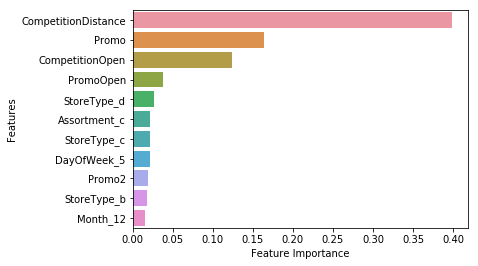

In [27]:
feature_imp_top10 = feature_imp.loc[feature_imp.Importance>0.015,:]
ax = sns.barplot(x="Importance", y="Features", data=feature_imp_top10)
ax.set(xlabel='Feature Importance', ylabel='Features')

# <u> 5. Validity of the Finding <u>

## Finding 1: Sales vs Competition
### Summary of Finding 1: There is a possible trend of more customers buying at Rossmann before competition opens, then a sudden drop once it opens. The sales decreasing effect can last relative long time. This effect is most obvious among those stores locate near their comopetitors. But the salse abosule volume of them are still the highest, possiblely due to high traffic drawn by more stores. 

### Validity of Finding

###  1.1 How Does New Competition Affect Sales

In [28]:
train_org = pd.read_csv('train.csv')
store = pd.read_csv('store.csv')

In [29]:
store['CompDistBin'] = pd.qcut(store.CompetitionDistance, 5, 
                               labels = ['1 quantile','2 quantile','3 quantile','4 quantile','5 quantile'])

In [30]:
store.CompetitionOpenSinceMonth = store.CompetitionOpenSinceMonth.fillna(1).astype(int).astype(str)
store.CompetitionOpenSinceYear = store.CompetitionOpenSinceYear.fillna(1900).astype(int).astype(str)

In [31]:
store['CompOpenDate'] = store.CompetitionOpenSinceYear+'-'+store.CompetitionOpenSinceMonth+'-01'
store['CompOpenDate'] = pd.to_datetime(store['CompOpenDate'])

In [32]:
df = pd.merge(train_org, store, how = 'left',on='Store')

create competition comparison data frame when sales data is available for new stores

In [33]:
df = df.loc[(df.CompOpenDate > datetime(2013,1,1))&(df.CompOpenDate<datetime(2015,7,31))&(df.Sales>0),:]

In [34]:
import seaborn as sns

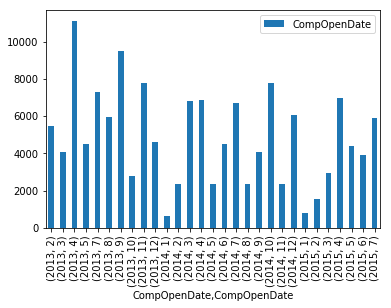

In [35]:
date = df[['CompOpenDate']]
date.groupby([date["CompOpenDate"].dt.year, date["CompOpenDate"].dt.month]).count().plot(kind="bar")

The above plot shows that new competition for Rossmann appears to have arrived fairly randomly for the period in which we have sales data.

Now we can see if there is a noticeable trend after stores open:
building very simple model sales prediction models — which do not include any competition effects — and looking at the residuals can help isolate the effects of competition and bring all stores to a more similar “level”.

In [36]:
df['AvgSpC'] = df.Sales/df.Customers

In [37]:
df.Date = pd.to_datetime(df.Date)

In [38]:
df['IsCompOpen'] = np.where(df.Date>df.CompOpenDate,1,0)
df.loc[(df.CompetitionDistance.notnull())&(df.CompOpenDate.isnull()),'IsCompOpen']=1

In [39]:
df['DaysSinceNewComp'] = (df.Date-df.CompOpenDate).astype(str).apply(lambda x : x.split()[0]).astype(int)
df = df.loc[(df.DaysSinceNewComp<=365)&(df.DaysSinceNewComp>=-365),:]

In [40]:
dayofweek = pd.get_dummies(df.DayOfWeek)
store = pd.get_dummies(df.Store)
stateholiday =pd.get_dummies(df.StateHoliday)
promo = df.Promo.reshape(89274,1)

In [41]:
df.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open',
       u'Promo', u'StateHoliday', u'SchoolHoliday', u'StoreType',
       u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth',
       u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek',
       u'Promo2SinceYear', u'PromoInterval', u'CompDistBin', u'CompOpenDate',
       u'AvgSpC', u'IsCompOpen', u'DaysSinceNewComp'],
      dtype='object')

In [42]:
x_train_lr = np.hstack((dayofweek,store,stateholiday,promo))

In [43]:
# build simple linear regression models to isolate competition effect
lr_cust = LinearRegression()
lr_cust.fit(X= x_train_lr,y=df.Customers.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [44]:
lr_aspc = LinearRegression()
lr_aspc.fit(X=x_train_lr,y=df.AvgSpC.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [45]:
df['res_lr_cust'] = df.Customers - lr_cust.predict(x_train_lr)

In [46]:
df['res_lr_aspc'] = df.AvgSpC - lr_aspc.predict(x_train_lr)

In [47]:
df_agg = df.groupby('DaysSinceNewComp').agg({'Date':'size','IsCompOpen':max,'res_lr_cust':'median','res_lr_aspc':'median'}).reset_index()

In [48]:
df_agg.head()

,DaysSinceNewComp,Date,res_lr_cust,IsCompOpen,res_lr_aspc
0,-365,65,47.6562,0,0.2342
1,-364,91,63.1875,0,0.0654
2,-363,78,25.5625,0,-0.1685
3,-362,93,17.4062,0,-0.0884
4,-361,99,-14.6562,0,-0.1859


In [49]:
from scipy.interpolate import spline

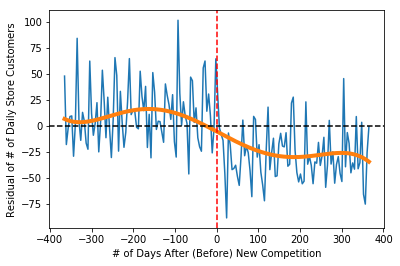

In [50]:
xnew = np.linspace(df_agg.DaysSinceNewComp.min(),df_agg.DaysSinceNewComp.max(),170)
power_smooth = spline(df_agg.DaysSinceNewComp,df_agg.res_lr_cust,xnew,order = 3)

z = np.polyfit(df_agg.DaysSinceNewComp, df_agg.res_lr_cust, deg=5)
p = np.poly1d(z)

plt.plot(xnew,power_smooth)
plt.plot(df_agg.DaysSinceNewComp,p(df_agg.DaysSinceNewComp),linewidth=4,)
plt.axvline(x=0,color='red',linestyle='--')
plt.axhline(y=0,color='k',linestyle='--')
plt.xlabel('# of Days After (Before) New Competition')
plt.ylabel('Residual of # of Daily Store Customers')
plt.show()

The plot above now shows a possible trend of more customers buying at Rossmann before competition opens, then an increasing drop once it opens. 

### 1.2 How does does competition distance affect the opening of a new store?

In [51]:
df_agg_2 = df.groupby(['DaysSinceNewComp','CompDistBin']
                     ).agg({'Date':'size','IsCompOpen':max,'res_lr_cust':'median','res_lr_aspc':'median'}
                          ).reset_index()

In [52]:
df_agg_2.head()

,DaysSinceNewComp,CompDistBin,Date,res_lr_cust,IsCompOpen,res_lr_aspc
0,-365,1 quantile,11,73.0000,0,0.4422
1,-365,2 quantile,14,46.3438,0,0.2928
2,-365,3 quantile,15,130.8125,0,0.1061
3,-365,4 quantile,12,29.0000,0,0.3249
4,-365,5 quantile,13,9.8125,0,-0.2134


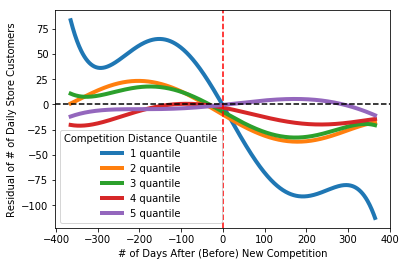

In [53]:
#xnew_1 = np.linspace(df_agg_2[df_agg_2.CompDistBin=='1 quantile'].DaysSinceNewComp.min(),df_agg_2[df_agg_2.CompDistBin=='1 quantile'].DaysSinceNewComp.max(),170)
#power_smooth_1 = spline(df_agg_2[df_agg_2.CompDistBin=='1 quantile'].DaysSinceNewComp,df_agg_2[df_agg_2.CompDistBin=='1 quantile'].res_lr_cust,xnew)

z_1 = np.polyfit(df_agg_2[df_agg_2.CompDistBin=='1 quantile'].DaysSinceNewComp, df_agg_2[df_agg_2.CompDistBin=='1 quantile'].res_lr_cust, deg=5)
p_1 = np.poly1d(z_1)

z_2 = np.polyfit(df_agg_2[df_agg_2.CompDistBin=='2 quantile'].DaysSinceNewComp, df_agg_2[df_agg_2.CompDistBin=='2 quantile'].res_lr_cust, deg=5)
p_2 = np.poly1d(z_2)

z_3 = np.polyfit(df_agg_2[df_agg_2.CompDistBin=='3 quantile'].DaysSinceNewComp, df_agg_2[df_agg_2.CompDistBin=='3 quantile'].res_lr_cust, deg=5)
p_3 = np.poly1d(z_3)

z_4 = np.polyfit(df_agg_2[df_agg_2.CompDistBin=='4 quantile'].DaysSinceNewComp, df_agg_2[df_agg_2.CompDistBin=='4 quantile'].res_lr_cust, deg=5)
p_4 = np.poly1d(z_4)
z_5 = np.polyfit(df_agg_2[df_agg_2.CompDistBin=='5 quantile'].DaysSinceNewComp, df_agg_2[df_agg_2.CompDistBin=='5 quantile'].res_lr_cust, deg=5)
p_5 = np.poly1d(z_5)

#plt.plot(xnew_1,power_smooth_1)
plt.plot(df_agg_2[df_agg_2.CompDistBin=='1 quantile'].DaysSinceNewComp,p_1(df_agg_2[df_agg_2.CompDistBin=='1 quantile'].DaysSinceNewComp),linewidth=4,label='1 quantile')
plt.plot(df_agg_2[df_agg_2.CompDistBin=='2 quantile'].DaysSinceNewComp,p_2(df_agg_2[df_agg_2.CompDistBin=='2 quantile'].DaysSinceNewComp),linewidth=4,label='2 quantile')
plt.plot(df_agg_2[df_agg_2.CompDistBin=='3 quantile'].DaysSinceNewComp,p_3(df_agg_2[df_agg_2.CompDistBin=='3 quantile'].DaysSinceNewComp),linewidth=4,label='3 quantile')
plt.plot(df_agg_2[df_agg_2.CompDistBin=='4 quantile'].DaysSinceNewComp,p_4(df_agg_2[df_agg_2.CompDistBin=='4 quantile'].DaysSinceNewComp),linewidth=4,label='4 quantile')
plt.plot(df_agg_2[df_agg_2.CompDistBin=='5 quantile'].DaysSinceNewComp,p_5(df_agg_2[df_agg_2.CompDistBin=='5 quantile'].DaysSinceNewComp),linewidth=4,label='5 quantile')


plt.axvline(x=0,color='red',linestyle='--')
plt.axhline(y=0,color='k',linestyle='--')
plt.legend(title='Competition Distance Quantile')
plt.xlabel('# of Days After (Before) New Competition')
plt.ylabel('Residual of # of Daily Store Customers')
plt.show()

The pattern here stands out. Stores that have the closest competition are in the 1st quintile, and the effect of new competition opening up for them is by far the strongest. The effects decrease in magnitude for the 2nd and 3rd quintiles, respectively. In contrast, the 4th and 5th quintiles — with competition the furthest away — appear to not be affected at all when new competition opens. 

Overall, new competition and that competition distance strongly affects Rossmann sales. The magnitude of these effects suggests this insight can be valuable for both building sales forecasting models as business strategy in planning store locations, anticipating new competition, and reacting to new competition.

### Finding 1 Maganerial Insight: Though new competitors might attract some sales from those stores, the sales bases are still higher than those of stores in other areas. When opening new stores, this tradeoff has to be considered when deciding store location.  Overall, opening stores in busy shopping district is still worth consideration if there's no existing Rossmann stores nearby. Additionally, the stores locate near competitors should differentiate the products to be more competitive to attract customers.

### FInding 1 Machine Learning Mastery: RandomizedSearch for finding best parameters

In [54]:
param_dist={'n_estimators':[20,30],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]}

In [55]:
n_iter_search = 10
rfr = RandomForestRegressor(bootstrap=True)
random_search = RandomizedSearchCV(rfr, param_distributions=param_dist,
                                   n_iter=n_iter_search)

In [56]:
random_search.fit(dtrain_dummied, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [20, 30], 'max_features': ['auto', 'sqrt'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [57]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.882 (std: 0.000)
Parameters: {'n_estimators': 30, 'min_samples_split': 5, 'max_features': 'auto', 'min_samples_leaf': 1}

Model with rank: 2
Mean validation score: 0.881 (std: 0.000)
Parameters: {'n_estimators': 30, 'min_samples_split': 5, 'max_features': 'auto', 'min_samples_leaf': 2}

Model with rank: 3
Mean validation score: 0.881 (std: 0.000)
Parameters: {'n_estimators': 30, 'min_samples_split': 10, 'max_features': 'auto', 'min_samples_leaf': 1}



In [58]:
random_search.best_params_

{'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 30}

In [59]:
rf2 = RandomForestRegressor(n_jobs=-1, n_estimators=30,bootstrap=True,max_features='auto',min_samples_leaf=1,min_samples_split=5)
rf2.fit(dtrain_dummied, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [60]:
yhat2 = rf2.predict(dvalid_dummied)
error = rmspe(X_valid.Sales.values, np.expm1(yhat2))
print('RMSPE: {:.6f}'.format(error))
print('MSE',str(mean_squared_error(X_valid.Sales.values, np.expm1(yhat2))))

RMSPE: 0.147277
('MSE', '1120940.7869290677')


In [61]:
ypred = rf2.predict(dvalid_dummied)

[Text(0,0.5,u'Predicted Sales'), Text(0.5,0,u'True Sales in Validation Data')]

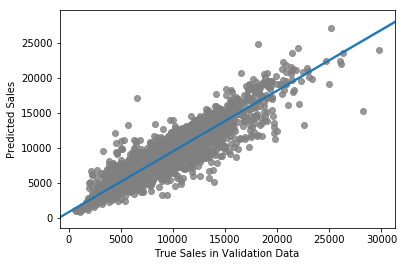

In [62]:
ax = sns.regplot(x=X_valid.Sales.values, y=np.expm1(ypred),scatter_kws={"color": "grey"},ci=95)
ax.set(xlabel='True Sales in Validation Data', ylabel='Predicted Sales')

In [63]:
from sklearn.metrics import mean_squared_error

In [64]:
error = rmspe(X_valid.Sales.values, np.expm1(ypred))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.147277


In [65]:
feature_imp = pd.DataFrame({'Features':dtrain_dummied.columns, 'Importance':rf2.feature_importances_}
                          ).sort_values('Importance', ascending=False)
feature_imp

,Features,Importance
0,CompetitionDistance,4.0316e-01
1,Promo,1.6710e-01
4,CompetitionOpen,1.2211e-01
5,PromoOpen,3.7363e-02
9,StoreType_d,2.6432e-02
11,Assortment_c,2.2115e-02
8,StoreType_c,2.1583e-02
16,DayOfWeek_5,2.1303e-02
2,Promo2,1.8949e-02
7,StoreType_b,1.7373e-02


[Text(0,0.5,u'Features'), Text(0.5,0,u'Feature Importance')]

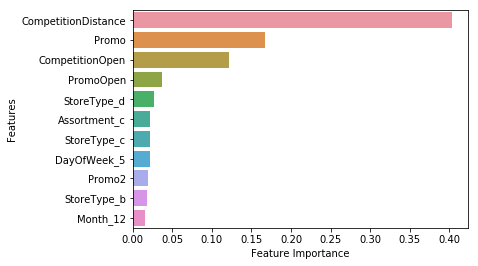

In [66]:
feature_imp_top10 = feature_imp.loc[feature_imp.Importance>0.015,:]
ax = sns.barplot(x="Importance", y="Features", data=feature_imp_top10)
ax.set(xlabel='Feature Importance', ylabel='Features')

<b>In conclusion, the regression verifies that both new competition and competition distance play important role in sales.</b>

## Finding 2: Sales vs StoreType
### Summary of Finding: Type B store is the most popular type of store and attracts the highest average sales. In terms of sales per customer, type D store stands out. Interestingly, only type B store has the assortment level c (extra product mix).

### Validity of Finding

In [56]:
store = pd.read_csv('store.csv')

In [57]:
total = train_org[(train_org.Open == 1) & (train_org.Sales != 0)]

In [58]:
total = pd.merge(total, store, how = 'left',on='Store')

In [59]:
total['Sales_per_Customer'] = total['Sales'] / total['Customers']

In [60]:
total.groupby('StoreType')['Sales','Customers','Sales_per_Customer'].describe()

Sales                                                            \
              count        mean        std     min      25%     50%       75%   
StoreType                                                                       
a          457042.0   6925.6980  3277.3516    46.0  4695.25  6285.0   8406.00   
b           15560.0  10233.3801  5155.7299  1252.0  6345.75  9130.0  13184.25   
c          112968.0   6933.1264  2896.9586   133.0  4916.00  6408.0   8349.25   
d          258768.0   6822.3001  2556.4015   538.0  5050.00  6395.0   8123.25   

                   Customers                                              \
               max     count       mean       std    min     25%     50%   
StoreType                                                                  
a          41551.0  457042.0   795.4224  387.5165    8.0   547.0   720.0   
b          38722.0   15560.0  2022.2118  910.6871  219.0  1255.0  1839.5   
c          31448.0  112968.0   815.5381  329.6700   18.0   583.0   756.0   
d          38037.0  258768.0   606.3539  199.2471   64.0   464.0   577.0   

                          Sales_per_Customer                                   \
              75%     max              count     mean     std     min     25%   
StoreType                                                                       
a           949.0  7388.0           457042.0   8.8463  1.6909  3.6354  7.6119   
b          2751.0  5494.0            15560.0   5.1334  1.2540  2.7491  4.0396   
c           981.0  3096.0           112968.0   8.6262  1.6943  3.3825  7.4170   
d           716.0  2239.0           258768.0  11.2779  1.9907  4.8813  9.8733   

                                      
               50%      75%      max  
StoreType                             
a           8.6314   9.8994  29.8776  
b           4.9870   6.1088   9.2035  
c           8.4247   9.6431  64.9579  
d          11.1950  12.5603  57.6150

In [61]:
model = total.groupby(['StoreType','Assortment']).agg(
    {'Sales':'mean','Customers':'mean','Sales_per_Customer':'mean','Store':'count'}).reset_index()

In [62]:
model

,StoreType,Assortment,Customers,Sales,Store,Sales_per_Customer
0,a,a,759.3111,6538.1890,286028,8.7433
1,a,c,855.8200,7573.8228,171014,9.0185
2,b,a,1804.9830,11133.9930,6409,6.2828
3,b,b,2067.5502,8642.5036,8209,4.1637
4,b,c,3105.0531,17969.5563,942,5.7636
5,c,a,839.9632,6835.7486,58554,8.2578
6,c,c,789.2546,7037.9131,54414,9.0227
7,d,a,584.0331,6433.7561,93884,11.0502
8,d,c,619.0633,7043.5348,164884,11.4075


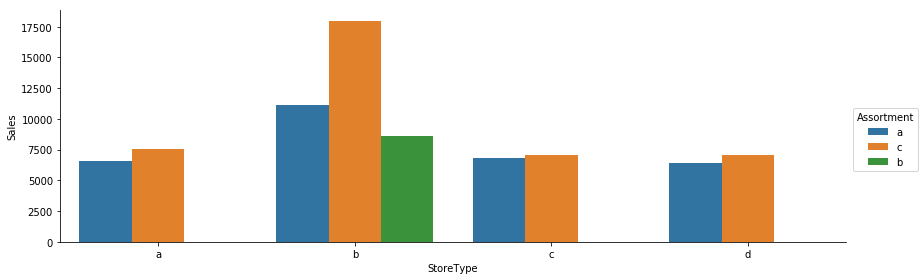

In [63]:
sns.factorplot(x='StoreType', y='Sales', hue='Assortment',data=model, kind='bar',aspect=3)

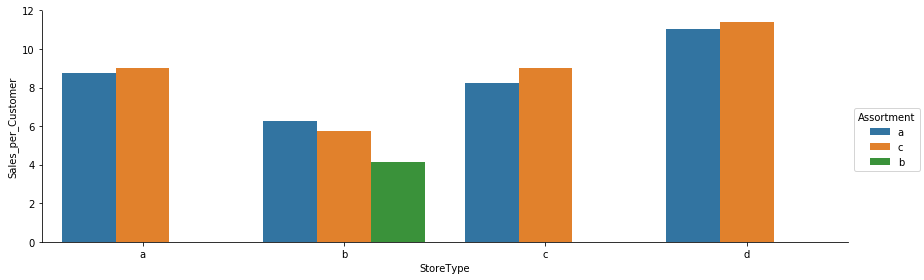

In [64]:
sns.factorplot(x='StoreType', y='Sales_per_Customer', hue='Assortment'
               ,data=model, kind='bar',aspect=3)

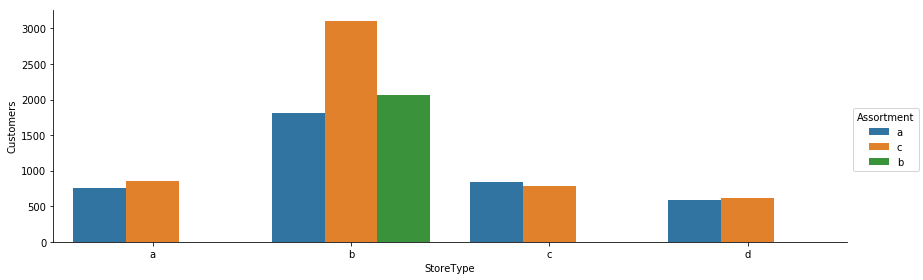

In [65]:
sns.factorplot(x='StoreType', y='Customers', hue='Assortment',data=model, kind='bar',aspect=3)

<b>Conclusion</b>: From the graph, we can verify that different store type affect sales. Type B store is the most popular type store in terms of sales for all level assortments. Also, only type B store has assortment b (extra).However, in term of sales per customer, type D store stands out for assortment levels a and c. Type B store with assortment level b has the least number of sale_per_customer.

In [66]:
store_number = store.groupby(['StoreType','Assortment'
                            ]).size().reset_index().rename(columns = {0:'number'})

In [67]:
store_number

,StoreType,Assortment,number
0,a,a,381
1,a,c,221
2,b,a,7
3,b,b,9
4,b,c,1
5,c,a,77
6,c,c,71
7,d,a,128
8,d,c,220


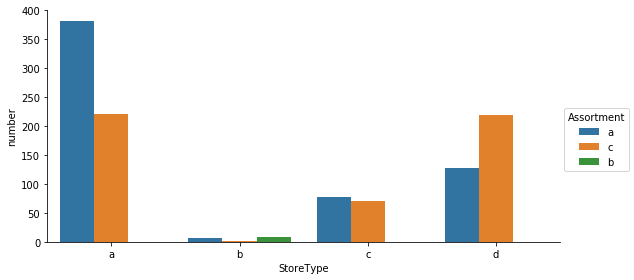

In [68]:
sns.factorplot(x = 'StoreType', y ='number', hue = 'Assortment', data = store_number, kind = 'bar',aspect =2)

There are reasons that B-type store has the largest average sales: firstly, type B has much more customers than other types; secondly, type B has less number of stores; thirdly, the Type B has been opened almost everyday except for temperory decoration; fourthly, type B has more product lines (assortments). Our guessing: store type B is the store located in the busy business zone with huge traffic of population, usually big city.

### Finding 2 Managerial Insight: Since store type B attracts most average sales, company can open more type B store when the goal is to increase sales; or company can set up more type D store when the goal is to increase sales per customer. Furthermore, becasue assortment c in store type B leads sales, company should try to add extra assortment(c) in store type a,c,d to see if the additional assortment increases sales.

### Finding 2 Machine Learning Mastery: Decision Tree

In [69]:
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

In [70]:
dt = tree.DecisionTreeRegressor(max_depth=2)

In [71]:
X=dtrain_dummied

In [72]:
Y=y_train

In [73]:
dt.fit(X,Y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

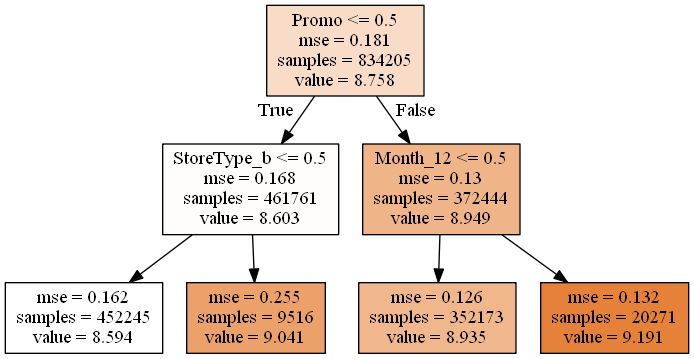

In [74]:
# This code will visualize a decision tree dt, trained with the attributes in X and the class labels in Y
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

<b>Conclusion</b> From the decision tree, we can verify that store type B contributes higher sales when there are no promo.

## Finding 3: Sales vs Promotion
### Summary: Promotion increases sales for every type of stores, especially for stores with lower sales. Mondays' sales e are more responsive to promotion activities than the other days of the week.  

### Validation Process

In [75]:
df = train[['Promo','Sales']]

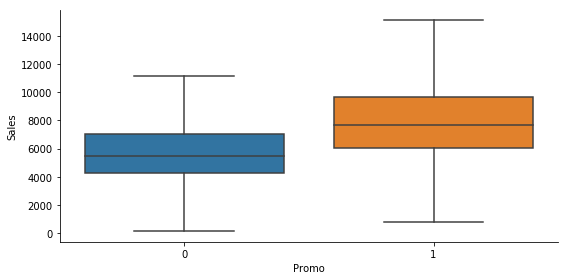

In [76]:
sns.factorplot(x='Promo', y='Sales',data = df,kind = 'box',aspect =2,showfliers=False )

<b> Promotion works for all types of stores and times. But smaller sales might benefit more.<b>

In [77]:
df=train[['monthStr','Sales','StoreType','Promo']]

In [78]:
c = '#386B7F'

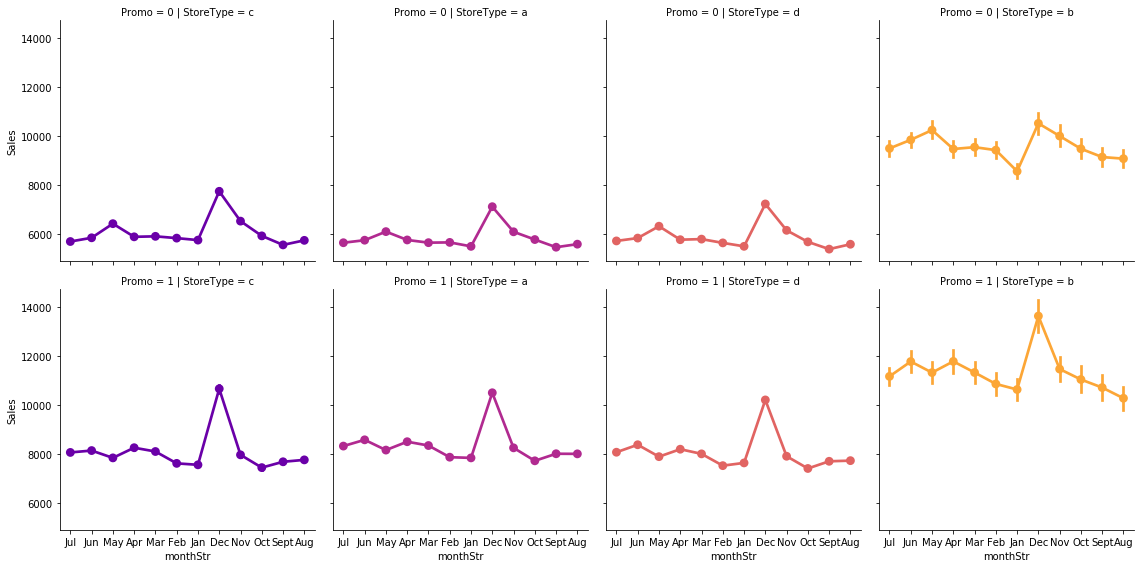

In [79]:
sns.factorplot(data = df, x = 'monthStr', y = "Sales", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c) 

<b>Potential Timing: Sunday booms. Mondays'sales are the second best. <b>

In [80]:
df = train[['DayOfWeek','Sales']]

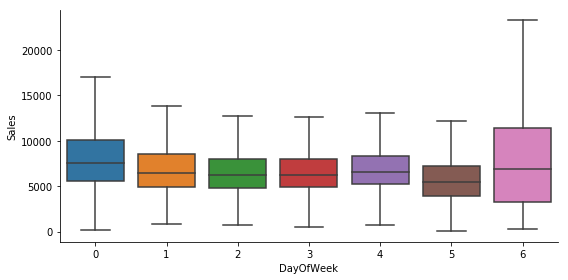

In [81]:
sns.factorplot(x='DayOfWeek', y='Sales', data=df, kind ='box', aspect =2,showfliers=False)

<b>Most stores close on Sunday. Europeans don't work on Sunday.<b>

In [82]:
train_org = pd.read_csv("train.csv")
full_train = train_org.merge(store, how='left', on ='Store')

In [83]:
full_weekend = full_train[full_train.DayOfWeek==7]

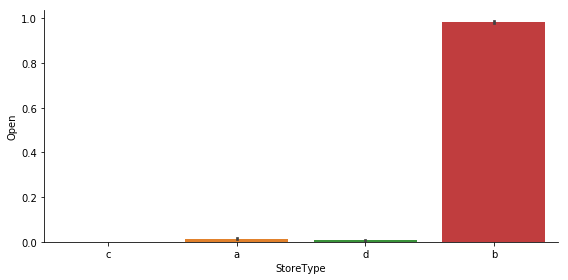

In [84]:
sns.factorplot(x='StoreType',y='Open',data=full_weekend,kind='bar',aspect=2)

<b>Promo levels are almost constant on weekdays.<b>

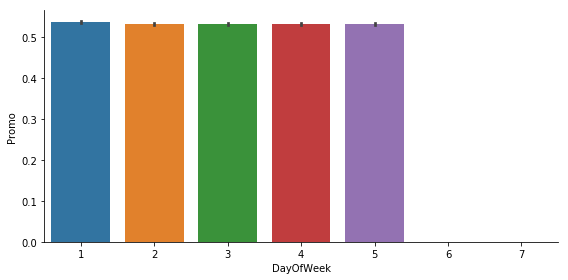

In [85]:
sns.factorplot(x='DayOfWeek',y='Promo',data=full_train,kind='bar',aspect=2)

<b> Give similar promo level as stated above, Mondays seem to be most responsive to Promo activies.<b>

In [86]:
df = train[['DayOfWeek','Promo','Sales']]

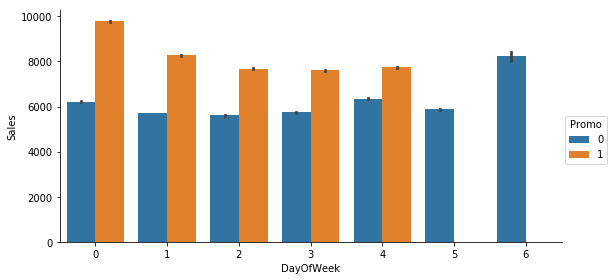

In [87]:
sns.factorplot(x='DayOfWeek', y='Sales',hue='Promo', data=df, kind ='bar', aspect =2)

### Finding 3 Managerial Insight: Do promotions on Monday and more on store type a,c,d, which would be more effective than other timing and places. People are eager to buy after a no-store weekend.

### Finding 3 Machine Learning Mastery: Lenear Regression find the interaction effect of Promo*Monday, Promo*StoreTypes

In [88]:
dtrain_interact = dtrain_dummied

In [89]:
dvalid_interact = dvalid_dummied

In [90]:
dtrain_interact['StoreType'] = dtrain_interact.StoreType_b+dtrain_interact.StoreType_c+dtrain_interact.StoreType_d
dvalid_interact['StoreType'] = dvalid_interact.StoreType_b+dvalid_interact.StoreType_c+dvalid_interact.StoreType_d

In [91]:
dtrain_interact['StoreType_a'] = dtrain_interact.StoreType.apply(
    lambda x: 1 if x ==0 else 0)
dvalid_interact['StoreType_a'] = dvalid_interact.StoreType.apply(
    lambda x: 1 if x ==0 else 0)

In [92]:
dtrain_interact.drop(['StoreType','StoreType_b'],axis=1, inplace=True)
dvalid_interact.drop(['StoreType','StoreType_b'],axis=1, inplace=True)

<b> Create interaction terms for Promo*Monday, Promo*StoreTypes<b>

In [93]:
dtrain_interact.columns

Index([u'CompetitionDistance', u'Promo', u'Promo2', u'SchoolHoliday',
       u'CompetitionOpen', u'PromoOpen', u'IsPromoMonth', u'StoreType_c',
       u'StoreType_d', u'Assortment_b', u'Assortment_c', u'DayOfWeek_1',
       u'DayOfWeek_2', u'DayOfWeek_3', u'DayOfWeek_4', u'DayOfWeek_5',
       u'DayOfWeek_6', u'Year_2014', u'Year_2015', u'Month_2', u'Month_3',
       u'Month_4', u'Month_5', u'Month_6', u'Month_7', u'Month_8', u'Month_9',
       u'Month_10', u'Month_11', u'Month_12', u'WeekOfYear_2', u'WeekOfYear_3',
       u'WeekOfYear_4', u'WeekOfYear_5', u'WeekOfYear_6', u'WeekOfYear_7',
       u'WeekOfYear_8', u'WeekOfYear_9', u'WeekOfYear_10', u'WeekOfYear_11',
       u'WeekOfYear_12', u'WeekOfYear_13', u'WeekOfYear_14', u'WeekOfYear_15',
       u'WeekOfYear_16', u'WeekOfYear_17', u'WeekOfYear_18', u'WeekOfYear_19',
       u'WeekOfYear_20', u'WeekOfYear_21', u'WeekOfYear_22', u'WeekOfYear_23',
       u'WeekOfYear_24', u'WeekOfYear_25', u'WeekOfYear_26', u'WeekOfYear_27',
       u'W

In [94]:
dtrain_interact['Promo*Mon'] = dtrain_interact['Promo']*dtrain_interact['DayOfWeek_1']
dvalid_interact['Promo*Mon'] = dvalid_interact['Promo']*dvalid_interact['DayOfWeek_1']

In [95]:
dtrain_interact['Promo*StoreType_a'] = dtrain_interact['Promo']*dtrain_interact['StoreType_a']
dvalid_interact['Promo*StoreType_a'] = dvalid_interact['Promo']*dvalid_interact['StoreType_a']

In [96]:
dtrain_interact['Promo*StoreType_c'] = dtrain_interact['Promo']*dtrain_interact['StoreType_c']
dvalid_interact['Promo*StoreType_c'] = dvalid_interact['Promo']*dvalid_interact['StoreType_c']

In [97]:
dtrain_interact['Promo*StoreType_d'] = dtrain_interact['Promo']*dtrain_interact['StoreType_d']
dvalid_interact['Promo*StoreType_d'] = dvalid_interact['Promo']*dvalid_interact['StoreType_d']

<b> Try linear regression to see if the impacts of interaction terms are aligned with our findings<b>

In [98]:
lr =LinearRegression(normalize=True)

In [99]:
lr.fit(dtrain_interact,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

<b> Though RMSPE for linear regression model is much higher than random forest, the signs of coefficients can still be informative to support our finding.

In [100]:
ypred = lr.predict(dvalid_interact)
error = rmspe(X_valid.Sales.values, np.expm1(ypred))
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.428176


In [101]:
s = pd.Series({dtrain_interact.columns[i] : lr.coef_[i] for i in range(0,len(dtrain_interact.columns))})

In [102]:
s.sort_values(ascending = False).head(50)

WeekOfYear_40          3.4801e-01
WeekOfYear_51          3.4344e-01
WeekOfYear_44          2.6331e-01
WeekOfYear_37          2.5997e-01
WeekOfYear_48          2.5838e-01
Month_3                2.5233e-01
Promo*StoreType_a      2.4323e-01
WeekOfYear_36          2.4312e-01
WeekOfYear_41          2.1467e-01
WeekOfYear_52          1.9976e-01
WeekOfYear_39          1.9666e-01
WeekOfYear_38          1.8851e-01
Promo*StoreType_d      1.8249e-01
WeekOfYear_42          1.7087e-01
Promo*StoreType_c      1.6748e-01
Month_5                1.6602e-01
WeekOfYear_49          1.5634e-01
Month_6                1.4968e-01
WeekOfYear_45          1.4704e-01
Month_4                1.4660e-01
WeekOfYear_50          1.4160e-01
Month_2                1.2322e-01
WeekOfYear_43          1.2186e-01
WeekOfYear_35          1.2134e-01
Assortment_c           1.2036e-01
WeekOfYear_47          1.2030e-01
WeekOfYear_31          1.0364e-01
WeekOfYear_33          9.3625e-02
Promo                  9.2835e-02
WeekOfYear_32 

<b>Conclusion:</b> We find all interactions(Promo*Mon, Promo*StoreType_a, Promo*StoreType_c, Promo*StoreType_d) with positive signs, which supports finding 3.